In [1]:
!pip install openeo -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.9/315.9 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 206.8/206.8 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 34.7 MB/s eta 0:00:00


In [2]:

# --- Step 1: Imports ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler


สร้าง NDVI Image

สามารถสร้าง Polygon ใน https://geojson.io/#map=2/0/20 ละค่อยนำ Code มาใส่ได้

In [16]:
import openeo
import json
def read_json(filename: str) -> dict:
    with open(filename) as input:
        field = json.load(input)
    return field

# Connect to an openEO backend (CDSE public backend)
# copy link วางบน Browser Login ดาวน์โหลด NDVI Time series .json เพื่อนำเข้าใน Colab
conn = openeo.connect("https://openeo.dataspace.copernicus.eu").authenticate_oidc()


# Define bounding box (lat/lon) and date range
# สร้าง polygon
'''bbox = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              100.06885131321991,
              15.191613217686992
            ],
            [
              100.06885131321991,
              15.185366640008795
            ],
            [
              100.0769259128906,
              15.185366640008795
            ],
            [
              100.0769259128906,
              15.191613217686992
            ],
            [
              100.06885131321991,
              15.191613217686992
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}'''
bbox = read_json("Mapห้วยขาแข้ง.geojson")
start_date = "2017-01-01"
end_date = "2024-12-31"


# Load Sentinel-2 data cube
s2 = conn.load_collection(
"SENTINEL2_L2A",
spatial_extent=bbox,
temporal_extent=[start_date, end_date],
bands=["B04", "B08"]
)


# Compute NDVI: (B08 - B04) / (B08 + B04)
ndvi = (s2.band("B08") - s2.band("B04")) / (s2.band("B08") + s2.band("B04"))


# Aggregate NDVI by date
ndvi_ts = ndvi.aggregate_temporal_period(reducer="mean", period="dekad")
ndvi_ts = ndvi_ts.aggregate_spatial(geometries=bbox,reducer='mean')

# Download as JSON and convert to DataFrame
ndvi_ts.execute_batch(title='ndvi_timeseries1',filename="timeseries1.json")

Authenticated using refresh token.
0:00:00 Job 'j-25082703503442c68c6593895681727b': send 'start'
0:00:14 Job 'j-25082703503442c68c6593895681727b': created (progress 0%)
0:00:20 Job 'j-25082703503442c68c6593895681727b': created (progress 0%)
0:00:26 Job 'j-25082703503442c68c6593895681727b': created (progress 0%)
0:00:35 Job 'j-25082703503442c68c6593895681727b': running (progress N/A)
0:00:45 Job 'j-25082703503442c68c6593895681727b': running (progress N/A)
0:00:57 Job 'j-25082703503442c68c6593895681727b': running (progress N/A)
0:01:13 Job 'j-25082703503442c68c6593895681727b': running (progress N/A)
0:01:32 Job 'j-25082703503442c68c6593895681727b': running (progress N/A)
0:01:57 Job 'j-25082703503442c68c6593895681727b': running (progress N/A)
0:02:27 Job 'j-25082703503442c68c6593895681727b': running (progress N/A)
0:03:05 Job 'j-25082703503442c68c6593895681727b': running (progress N/A)
0:03:52 Job 'j-25082703503442c68c6593895681727b': running (progress N/A)
0:04:50 Job 'j-25082703503442

<BatchJob job_id='j-25082703503442c68c6593895681727b'>

In [18]:
import pandas as pd
df = pd.read_json("timeseries1.json")
df = df.T.reset_index()
df.columns = ["date", "ndvi"]
df["ndvi"] = df["ndvi"].apply(lambda x: x[0] if isinstance(x, list) else x)
print(df.head())

                       date      ndvi
0 2017-01-01 00:00:00+00:00       NaN
1 2017-01-11 00:00:00+00:00  0.370452
2 2017-01-21 00:00:00+00:00       NaN
3 2017-02-01 00:00:00+00:00  0.724168
4 2017-02-11 00:00:00+00:00  0.696691


<Axes: >

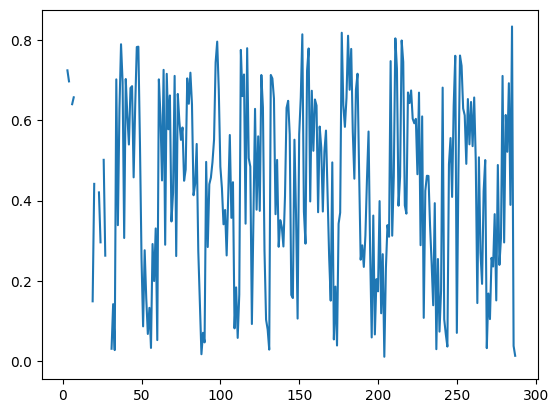

In [19]:
df.ndvi.plot()

In [20]:
# Scale data for RNN
scaler = MinMaxScaler()
df['ndvi_scaled'] = scaler.fit_transform(df[['ndvi']])

# Create sequences for supervised learning
def create_sequences(data, seq_length=30):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)
#แก้เป็น 20
SEQ_LEN = 20
X, y = create_sequences(df['ndvi_scaled'].values, SEQ_LEN)
X = np.nan_to_num(X)
y = np.nan_to_num(y)
# Train-test split
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("Training samples:", X_train.shape)


Training samples: (214, 20)


In [21]:

# --- Step 4: Build GRU Model ---
model = Sequential([
    GRU(64, return_sequences=True, input_shape=(SEQ_LEN, 1)),
    Dropout(0.2),
    GRU(32),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 20, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,305 (87.13 KB)

 Trainable params: 22,305 (87.13 KB)

 Non-trainable params: 0 (0.00 B)

In [22]:

# Reshape for GRU [samples, time steps, features]
X_train = X_train.reshape((X_train.shape[0], SEQ_LEN, 1))
X_test = X_test.reshape((X_test.shape[0], SEQ_LEN, 1))
# แก้เป็น 40
# --- Step 5: Train Model ---
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=10,
    batch_size=32
)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step - loss: 0.2448 - val_loss: 0.0770
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0938 - val_loss: 0.0902
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0725 - val_loss: 0.0724
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0712 - val_loss: 0.0738
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0658 - val_loss: 0.0714
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 0.0742 - val_loss: 0.0738
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0714 - val_loss: 0.0706
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0656 - val_loss: 0.0702
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0697 - val_loss: 0.0705
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0551 - val_loss: 0.0713


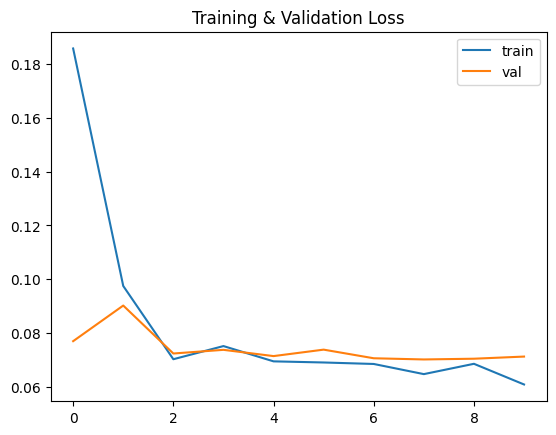

In [24]:

# Plot training loss
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step


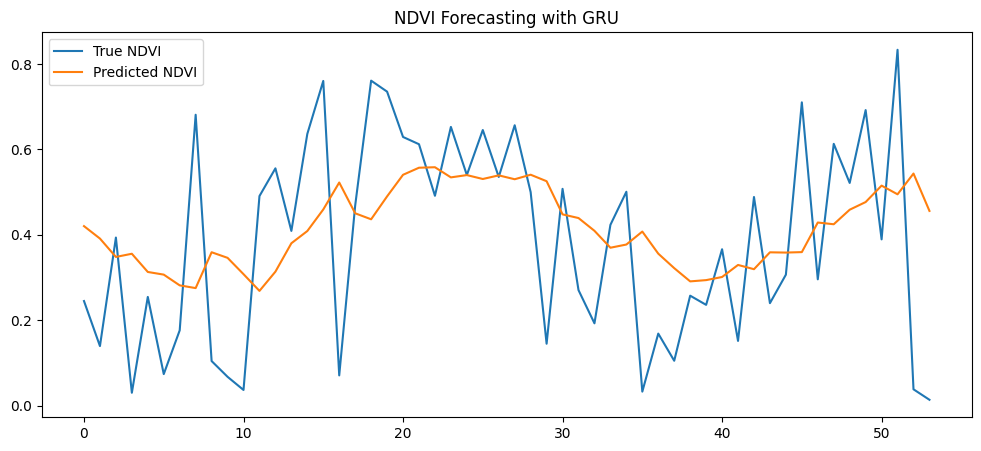

In [25]:

# --- Step 6: Evaluate Model ---
y_pred = model.predict(X_test)

# Inverse scale predictions
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))

plt.figure(figsize=(12,5))
plt.plot(y_test_rescaled, label='True NDVI')
plt.plot(y_pred_rescaled, label='Predicted NDVI')
plt.legend()
plt.title("NDVI Forecasting with GRU")
plt.show()
